# Model 2
This script uses the original [Wikiart](https://github.com/cs-chan/ArtGAN/blob/master/WikiArt%20Dataset/README.md) Dataset instead of deeplake

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data
from pprint import pprint
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import datetime

ImageFile.LOAD_TRUNCATED_IMAGES = True

C:\Users\nickd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Data
Transform dataset and split into training and validation subsets

In [2]:
root = "./data3/wikiart"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(227),
    # transforms.Normalize(mean= (-0.0953, -0.0682, -0.0931), std = (0.9244, 0.9452, 0.9501))
    # transforms.Normalize(mean=(0.6488, 0.5549, 0.5073), std=(0.2907, 0.2803, 0.2766)) # Expressionism, Impressionism, Realism
    # transforms.Normalize(mean = (0.4980, 0.4494, 0.3860), std=(0.2845, 0.2786, 0.2711))
    transforms.Normalize(mean = (0.4936, 0.4432, 0.3787), std=(0.2821, 0.2745, 0.2655))
])

'''
train data is a ImageFolder object.
ds.classes = list of the 24 classes in the dataset
ds.img = list of tuples of (img_path, label)
'''
dataset = datasets.ImageFolder(root=root, transform=transform)
print("- Number of train samples:", len(dataset))
print("- Classes:", dataset.classes, "| Length:", len(dataset.classes))
# print(dataset.imgs[20000])
# pprint("- Classes:\n", train_data.classes)

print("\nSplitting dataset into training and validation sets")
# Splitting Dataset into training and dataset

# splitting train val in a 0.8/0.2 ratio
train_len = int(len(dataset)*0.8)
val_len = len(dataset)- train_len
train, val = data.random_split(dataset, [train_len, val_len])
print("\t- Size of Training set:", len(train))
print("\t- Size of Validation set:", len(val))

# Dataloaders
train_dataloader = data.DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val, batch_size=32, shuffle=False, drop_last=True)

- Number of train samples: 24488
- Classes: ['Expressionism', 'Realism', 'Romanticism'] | Length: 3

Splitting dataset into training and validation sets
	- Size of Training set: 19590
	- Size of Validation set: 4898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([1, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 2,
        0, 0, 1, 1, 2, 0, 1, 1]) <class 'torch.Tensor'>


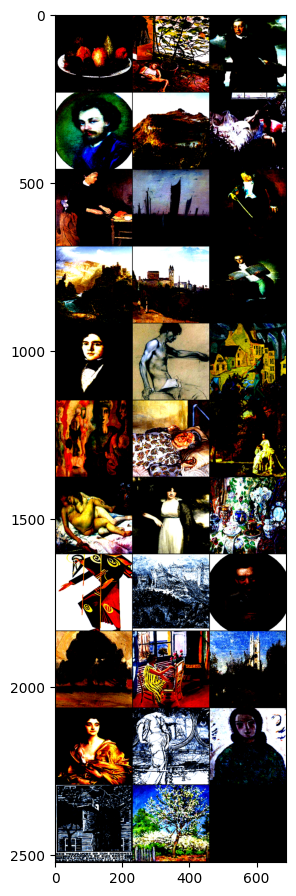

In [3]:
def show_transformed_images(dataset):
    dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)
    batch = next(iter(dataloader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels:", labels, type(labels))
    
show_transformed_images(dataset)

# Calculate Mean and Standard Deviation of Dataset Images
Values to be used to Normalize dataloader

In [4]:
'''
Calculating mean and standard deviation for transforms
REMEMBER TO USE A NON-NORMALIZED DATASET TO GET VALUES
'''

# def get_mean_and_std(loader):
#     mean, std = 0, 0
#     total_images_count = 0
#     for img, _ in loader:
#         batch_size = img.size(0)
#         img = img.view(batch_size, img.size(1), -1) # reshape images in batch
#         mean += img.mean(2).sum(0)
#         std += img.std(2).sum(0)
#         total_images_count += batch_size
        
#     mean /= total_images_count
#     std /= total_images_count
    
    # return mean, std

dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)

def get_mean_and_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3]) # B x W x H
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean, std

mean, std = get_mean_and_std(dataloader)
print("mean:", mean, " std: ", std, "")
## mean: (0.5322, 0.4754, 0.4146), std: (0.2907, 0.2803, 0.2766) -> all images
## mean: tensor([-0.0953, -0.0682, -0.0931]) | std: tensor([0.9244, 0.9452, 0.9501]) -> only Impressionism, Realism, and Romanticism
## mean = (0.4980, 0.4494, 0.3860), std=(0.2845, 0.2786, 0.2711) -> Expressionism, Realism, Romanticism, resized to 64x64
## tensor([0.5002, 0.4418, 0.3726])  std:  tensor([0.2802, 0.2686, 0.2566]), rezied to 64x64, cropped to 32 x 32
## mean: tensor([0.4936, 0.4432, 0.3787])  std:  tensor([0.2821, 0.2745, 0.2655]) -> Realism, Romanticism, Expressionism 227 x 227

KeyboardInterrupt: 

# Model 2: 8 layers
- 5 convolutional layers, 3 fully-connected layers
- Max-pooling is applied after 1st, 2nd, and 3rd convolutional layers
- Dropout is applied after 2 first 2 fully connected layers
- ReLu activation functions are used in all layers (we chose ReLu over Tanh for faster forward computations)
- Applied log softmax in output layer to compute probabilities (we are using Negative Log Likeligood Loss for training)

In [6]:

#   output= ((Input-filter size)/ stride)+1
class Net2(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # 3 fully connected layers
        # Apply dropout after first 2 fc
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, n_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1) # calculate probabilities
        return out
        
Net2(3)
        

Net2(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
 

# Training Loop and Validation Functions

In [7]:
def training_loop(train_loader, model, loss_fn, optimizer, device, n_epochs):
    print("Started Training at {}".format(datetime.datetime.now()))
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # move data to device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs) # compute output batch
            loss = loss_fn(outputs, labels) # compute loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        # if epoch == 1 or epoch % 10 == 0:
        # print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))
            
def validate(model, device, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.6f}".format(name , correct / total))

# Training
- Learning rate of 1e-4
- Stochastic Gradient Descent optimizer
- Added weight decay of 0.005 to help model generalize and avoid overfitting
- 80 epochs
- Negative Log Likelihood Loss function 

In [8]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}")
model = Net2(3)
# model = Net(32)
model = model.to(device)
# model = model2(3)
learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005)
n_epochs=80
loss_fn = nn.NLLLoss()

training_loop(n_epochs=n_epochs, train_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)


Training on device cuda
Started Training at 2022-12-16 22:41:19.189616
2022-12-16 22:47:17.039553 Epoch 1, Training loss 1.080511040157742
2022-12-16 22:53:04.430958 Epoch 2, Training loss 1.051273230828491
2022-12-16 23:02:44.509473 Epoch 3, Training loss 1.035774240501566
2022-12-16 23:14:25.751878 Epoch 4, Training loss 1.0233264386264327
2022-12-16 23:25:32.229211 Epoch 5, Training loss 1.011372058609732
2022-12-16 23:32:32.460891 Epoch 6, Training loss 0.9995549416619968
2022-12-16 23:39:30.226598 Epoch 7, Training loss 0.9877586185542586
2022-12-16 23:45:01.289284 Epoch 8, Training loss 0.9753727073373358
2022-12-16 23:50:32.230394 Epoch 9, Training loss 0.9646140526907117
2022-12-16 23:56:02.467080 Epoch 10, Training loss 0.9549574490660936
2022-12-17 00:01:32.964174 Epoch 11, Training loss 0.9412344424358381
2022-12-17 00:07:02.723066 Epoch 12, Training loss 0.9297002023146823
2022-12-17 00:12:32.416544 Epoch 13, Training loss 0.9231539058919046
2022-12-17 00:18:01.581944 Epoch

In [9]:
validate(model=model, device=device, train_loader=train_dataloader, val_loader=val_dataloader)

Accuracy train: 0.704044
Accuracy val: 0.643178


In [10]:
torch.save(model.state_dict(), './models/net2.pt')